In [1]:
import os
from glob import glob
import model.aotgan 
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset
import random
import numpy as np
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
from loss1 import loss as loss_module
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4" 
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

2024-06-07 14:09:06.960354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:09:07.757974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
params={'image_size':512,
        'rates':[1, 2, 4, 8],
        'block_num':8,
        'model':'aotgan',
        'gan_type':"smgan",
        'lrg':1e-4,
        'lrd':1e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':8,
        'epochs':500,
        'data_path':'../../data/dataset/adenoma/',
        'num_workers':4,
        'rec_loss':'1*L1+250*Style+0.1*Perceptual'
        }
losses = list(params['rec_loss'].split("+"))
params['rec_loss'] = {}
for l in losses:
    weight, name = l.split("*")
    params['rec_loss'][name] = float(weight)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, args,dataset):
        super(Dataset, self).__init__()
        self.w = self.h = args['image_size']

        # image and mask
        self.image_path =glob(args['data_path']+dataset+'/image/*.jpg')
        self.mask_path = [i.replace('/image','/mask') for i in self.image_path]

        #augmentation
        self.trans = transforms.Compose(
            [
                transforms.Resize(args['image_size'], interpolation=transforms.InterpolationMode.NEAREST),
                transforms.RandomResizedCrop(args['image_size']),
            ]
        )
        

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        # load image
        random_seed = 42
        random.seed(random_seed)  # Python의 random 함수에 대한 시드 설정
        torch.manual_seed(random_seed)
        image = Image.open(self.image_path[index]).convert("RGB")
        filename = os.path.basename(self.image_path[index])
        mask = Image.open(self.mask_path[index])
        mask = mask.convert("L")
        # augment
        torch.manual_seed(random_seed)
        image = F.to_tensor(self.trans(image)) * 2.0 - 1.0
        torch.manual_seed(random_seed)
        mask = F.to_tensor(self.trans(mask))
        
        return image, mask, filename
    
test_dataset=CustomDataset(params,'test')
test_dataloader = DataLoader(
        test_dataset,
        batch_size=params['batch_size'],
         shuffle=True, drop_last=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
netG =model.aotgan.InpaintGenerator(params).to(device)
optimG = torch.optim.Adam(netG.parameters(), lr=params['lrg'], betas=(params['beta1'], params['beta2']))

netD = model.aotgan.Discriminator().to(device)
optimD = torch.optim.Adam(netD.parameters(), lr=params['lrd'], betas=(params['beta1'], params['beta2']))
netG.load_state_dict(torch.load('../../model/aot-model_colon/generator_check.pt'),map_location=device)
netD.load_state_dict(torch.load('../../model/aot-model_colon/discriminator_check.pt',map_location=device))

NameError: name 'model' is not defined

In [ ]:
save_path='../../data/dataset/adenoma/test/result/'
with torch.no_grad():
    test=tqdm(test_dataloader)
    count=0
    for images, masks,filename in test:
        count+=1
        images, masks = images.to(device), masks.to(device)
        images_masked = (images * (1 - masks).float()) + masks
        pred_img = netG(images_masked, masks)
        comp_img = (1 - masks) * images + masks * pred_img
        for i in range(params['batch_size']):
            img3=np.transpose((pred_img[i].cpu().detach().numpy()/2+0.5)*255,(1,2,0))
            pillow_pred=Image.fromarray(img3.astype(np.uint8))
            pillow_pred.save(save_path+filename[i])
        

100%|██████████| 181/181 [01:02<00:00,  2.89it/s]


In [ ]:
img1=np.transpose((images[0].cpu().detach().numpy()/2+0.5)*255,(1,2,0))
img2=np.transpose((masks[0].cpu().detach().numpy())*255,(1,2,0))
img3=np.transpose((pred_img[0].cpu().detach().numpy()/2+0.5)*255,(1,2,0))

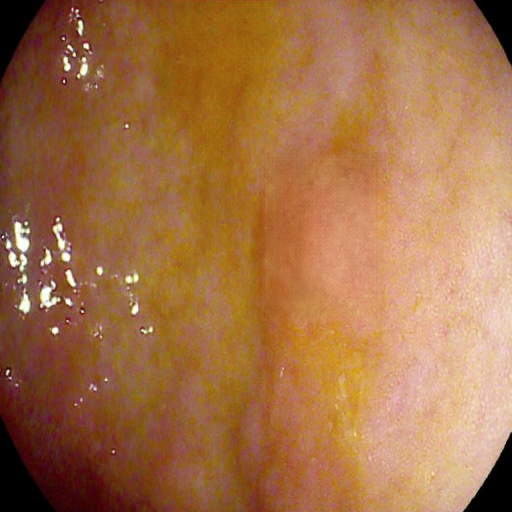

In [ ]:
pillow_mask=Image.fromarray(img2[:,:,0].astype(np.uint8))
pillow_image=Image.fromarray(img1.astype(np.uint8))
pillow_pred=Image.fromarray(img3.astype(np.uint8))
pillow_pred